In [1]:
import os
import re
import json
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../../yikyak_metadata.csv")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix

In [4]:
df.head()

,created_at,id,text,vote_total,comment_count,alias,group_id,index_code,text_clean,text_length,...,vader_pos,vader_compound,posts_prev_2h_all,posts_prev_2h_group,rel_posts_prev_2h,burst_z_group,burst_flag_group,log_vote_total,log_comment_count,log_posts_prev_2h_all
0,2024-12-14 05:19:32.783000+00:00,5b40eb58-8fa1-4215-9786-fd10c3d29cef,I think i just developed a campus crush holy fuck,23,1,Anonymous,1fcad7b1-fce2-4ae1-bd48-bd1917b62d98,UWgAiMSy,i think i just developed a campus crush holy fuck,49,...,0.000,-0.6249,0.0,0.0,0.000000,0.0,0,3.178054,0.693147,0.000000
1,2024-12-14 05:21:49.086000+00:00,c0201504-aa69-4dcf-9fa4-8308da1ec33b,can anyone with experience being an Spanish AT...,8,5,Anonymous,1fcad7b1-fce2-4ae1-bd48-bd1917b62d98,U76vdfxw,can anyone with experience being an spanish at...,251,...,0.155,0.8184,1.0,1.0,0.500000,0.0,0,2.197225,1.791759,0.693147
2,2024-12-14 05:39:31.456000+00:00,0e550dfd-42e2-4a67-87c6-86493a6b0bc3,All the guys I develop feelings for are taken 😭,30,1,Anonymous,1fcad7b1-fce2-4ae1-bd48-bd1917b62d98,2mWz7486,all the guys i develop feelings for are taken ...,47,...,0.000,0.0000,2.0,2.0,0.666667,0.0,0,3.433987,0.693147,1.098612
3,2024-12-14 09:08:31.173000+00:00,69a6e2f9-02bd-4c5a-a368-f90caad803f4,fml,6,0,Anonymous,1fcad7b1-fce2-4ae1-bd48-bd1917b62d98,DHDv82XB,fml,3,...,0.000,0.0000,0.0,0.0,0.000000,0.0,0,1.945910,0.000000,0.000000
4,2024-12-14 09:29:34.677000+00:00,0a8a6fa7-c5a9-4fdc-b610-b5b0b2379fb3,I know there are girls on this campus that lik...,15,2,Anonymous,1fcad7b1-fce2-4ae1-bd48-bd1917b62d98,egWizaDt,i know there are girls on this campus that lik...,126,...,0.054,-0.8462,1.0,1.0,0.500000,0.0,0,2.772589,1.098612,0.693147


In [5]:
print(df.shape)

(19126, 37)


In [6]:
TEXT_COL = "text_clean"
LABEL_COL = "high_engagement"
# Set aside numeric features
NUM_COLS = [
     "text_length", "created_hour", "first_person_count", "second_person_count", "first_person_ratio", "second_person_ratio",
    "disagree_count",  "conflict_count",  "exclamations", "questions",  "vader_compound",
    "posts_prev_2h_all",
"rel_posts_prev_2h",
"burst_z_group",
"burst_flag_group",
]

use_cols = [TEXT_COL, LABEL_COL] + NUM_COLS
df_model = df[use_cols].dropna().copy()

df_model.head()

,text_clean,high_engagement,text_length,created_hour,first_person_count,second_person_count,first_person_ratio,second_person_ratio,disagree_count,conflict_count,exclamations,questions,vader_compound,posts_prev_2h_all,rel_posts_prev_2h,burst_z_group,burst_flag_group
0,i think i just developed a campus crush holy fuck,0,49,5,2,0,0.040000,0.000000,0,0.0,0.0,0.0,-0.6249,0.0,0.000000,0.0,0
1,can anyone with experience being an spanish at...,0,251,5,2,2,0.007937,0.007937,0,0.0,0.0,2.0,0.8184,1.0,0.500000,0.0,0
2,all the guys i develop feelings for are taken ...,0,47,5,1,0,0.020833,0.000000,0,0.0,0.0,0.0,0.0000,2.0,0.666667,0.0,0
3,fml,0,3,9,0,0,0.000000,0.000000,0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0
4,i know there are girls on this campus that lik...,0,126,9,5,0,0.039370,0.000000,1,2.0,0.0,0.0,-0.8462,1.0,0.500000,0.0,0


In [7]:
# Replace infinities with NaN, then fill NaN
df_model[NUM_COLS] = df_model[NUM_COLS].replace([np.inf, -np.inf], np.nan)
df_model[NUM_COLS] = df_model[NUM_COLS].fillna(0)


In [8]:
X_train_df, X_test_df = train_test_split(
    df_model,
    test_size=0.2,
    random_state=42,
    stratify=df_model[LABEL_COL]
)

y_train = X_train_df[LABEL_COL].astype(int).values
y_test  = X_test_df[LABEL_COL].astype(int).values

tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_text = tfidf.fit_transform(X_train_df[TEXT_COL])
X_test_text  = tfidf.transform(X_test_df[TEXT_COL])


In [9]:
X_train_num = csr_matrix(X_train_df[NUM_COLS].astype(float).values)
X_test_num  = csr_matrix(X_test_df[NUM_COLS].astype(float).values)

X_train = hstack([X_train_text, X_train_num])
X_test  = hstack([X_test_text, X_test_num])

In [10]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

,n_estimators,400
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
pred = rf.predict(X_test)

print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print("\nReport:\n", classification_report(y_test, pred, digits=3))


Confusion matrix:
 [[3184  259]
 [ 296   86]]

Report:
               precision    recall  f1-score   support

           0      0.915     0.925     0.920      3443
           1      0.249     0.225     0.237       382

    accuracy                          0.855      3825
   macro avg      0.582     0.575     0.578      3825
weighted avg      0.848     0.855     0.852      3825



In [12]:
print("X_test rows:", X_test.shape[0])
print("y_test rows:", len(y_test))
print("pred rows:", len(pred))


X_test rows: 3825
y_test rows: 3825
pred rows: 3825


In [13]:
# safest: rebuild y_test from the original y and X_test_df index
y_test_aligned = y.loc[X_test_df.index]


NameError: name 'y' is not defined

In [14]:
pred = rf.predict(X_test)

print("Confusion matrix:\n", confusion_matrix(y_test_aligned, pred))
print("\nReport:\n", classification_report(y_test_aligned, pred, digits=3))


NameError: name 'y_test_aligned' is not defined

In [108]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced",          # or "balanced_subsample"
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [109]:
pred = clf.predict(X_test)

print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print("\nReport:\n", classification_report(y_test, pred, digits=3))


Confusion matrix:
 [[3440    3]
 [ 381    1]]

Report:
               precision    recall  f1-score   support

           0      0.900     0.999     0.947      3443
           1      0.250     0.003     0.005       382

    accuracy                          0.900      3825
   macro avg      0.575     0.501     0.476      3825
weighted avg      0.835     0.900     0.853      3825



In [15]:
from imblearn.ensemble import BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [16]:
clf_pred = clf.predict(X_test)

print("Confusion matrix:\n", confusion_matrix(y_test, clf_pred))
print("\nReport:\n", classification_report(y_test, pred, digits=3))


Confusion matrix:
 [[3010  433]
 [ 252  130]]

Report:
               precision    recall  f1-score   support

           0      0.915     0.925     0.920      3443
           1      0.249     0.225     0.237       382

    accuracy                          0.855      3825
   macro avg      0.582     0.575     0.578      3825
weighted avg      0.848     0.855     0.852      3825



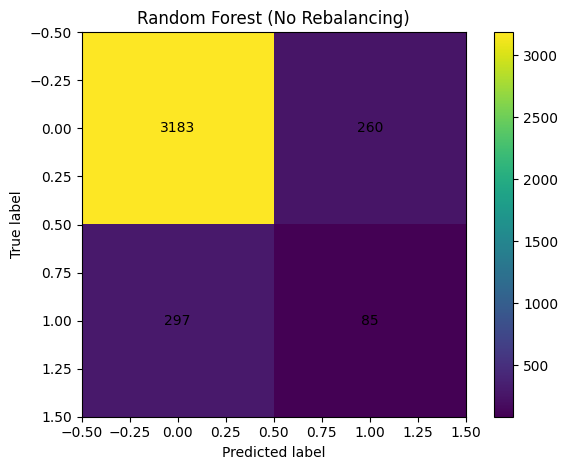

In [195]:
import matplotlib.pyplot as plt
# creating data vis
cm = confusion_matrix(y_test, pred)  # normal RF predictions

plt.figure()
plt.imshow(cm)
plt.title("Random Forest (No Rebalancing)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()

# add numbers to cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


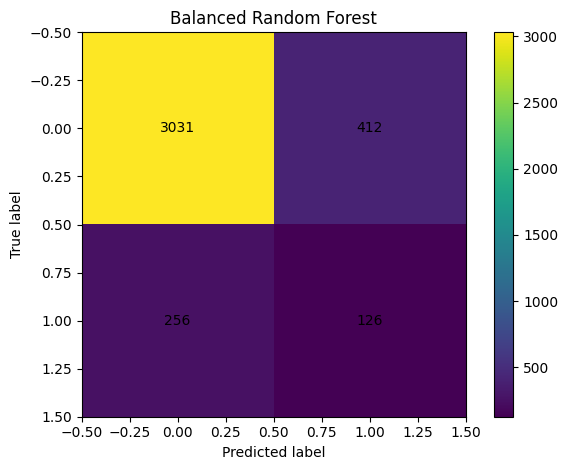

In [196]:
cm_bal = confusion_matrix(y_test, clf_pred)  # Balanced RF predictions

plt.figure()
plt.imshow(cm_bal)
plt.title("Balanced Random Forest")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()

for i in range(cm_bal.shape[0]):
    for j in range(cm_bal.shape[1]):
        plt.text(j, i, cm_bal[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()
